# WINE CLASSIFICATION #


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('winequality-red.csv')

In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df.duplicated().sum()

240

In [8]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
df = df.drop_duplicates()

In [11]:
df.duplicated().sum()

0

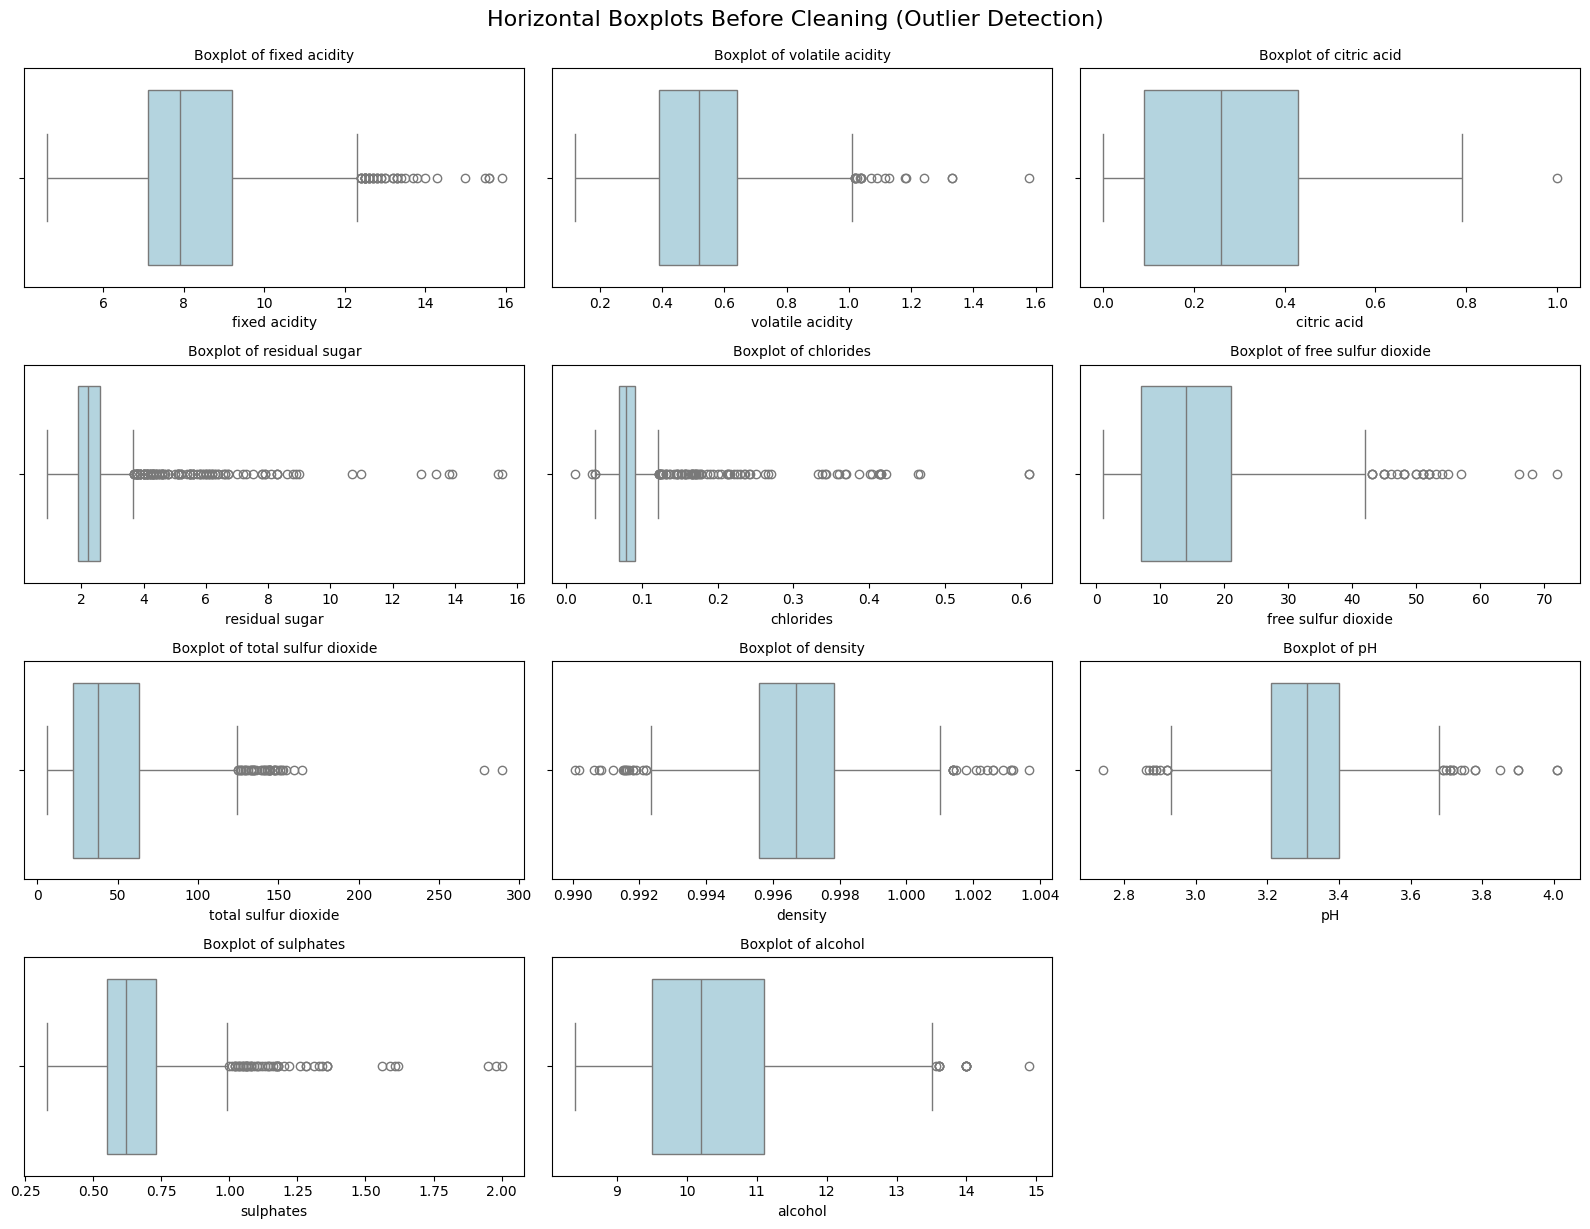

In [16]:
plt.figure(figsize=(16, 12))

# Loop to plot horizontal boxplots
for i, column in enumerate(df.columns[:-1], 1):  # Exclude 'quality'
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[column], color="lightblue", orient="h")
    plt.title(f'Boxplot of {column}', fontsize=10)
    plt.tight_layout()

# Overall title
plt.suptitle("Horizontal Boxplots Before Cleaning (Outlier Detection)", fontsize=16, y=1.02)
plt.show()

In [17]:
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] >= lower) & (dataframe[column] <= upper)]

features_to_clean = df.columns[df.columns != 'quality']  # All except target
for col in features_to_clean:
    df = remove_outliers_iqr(df, col)

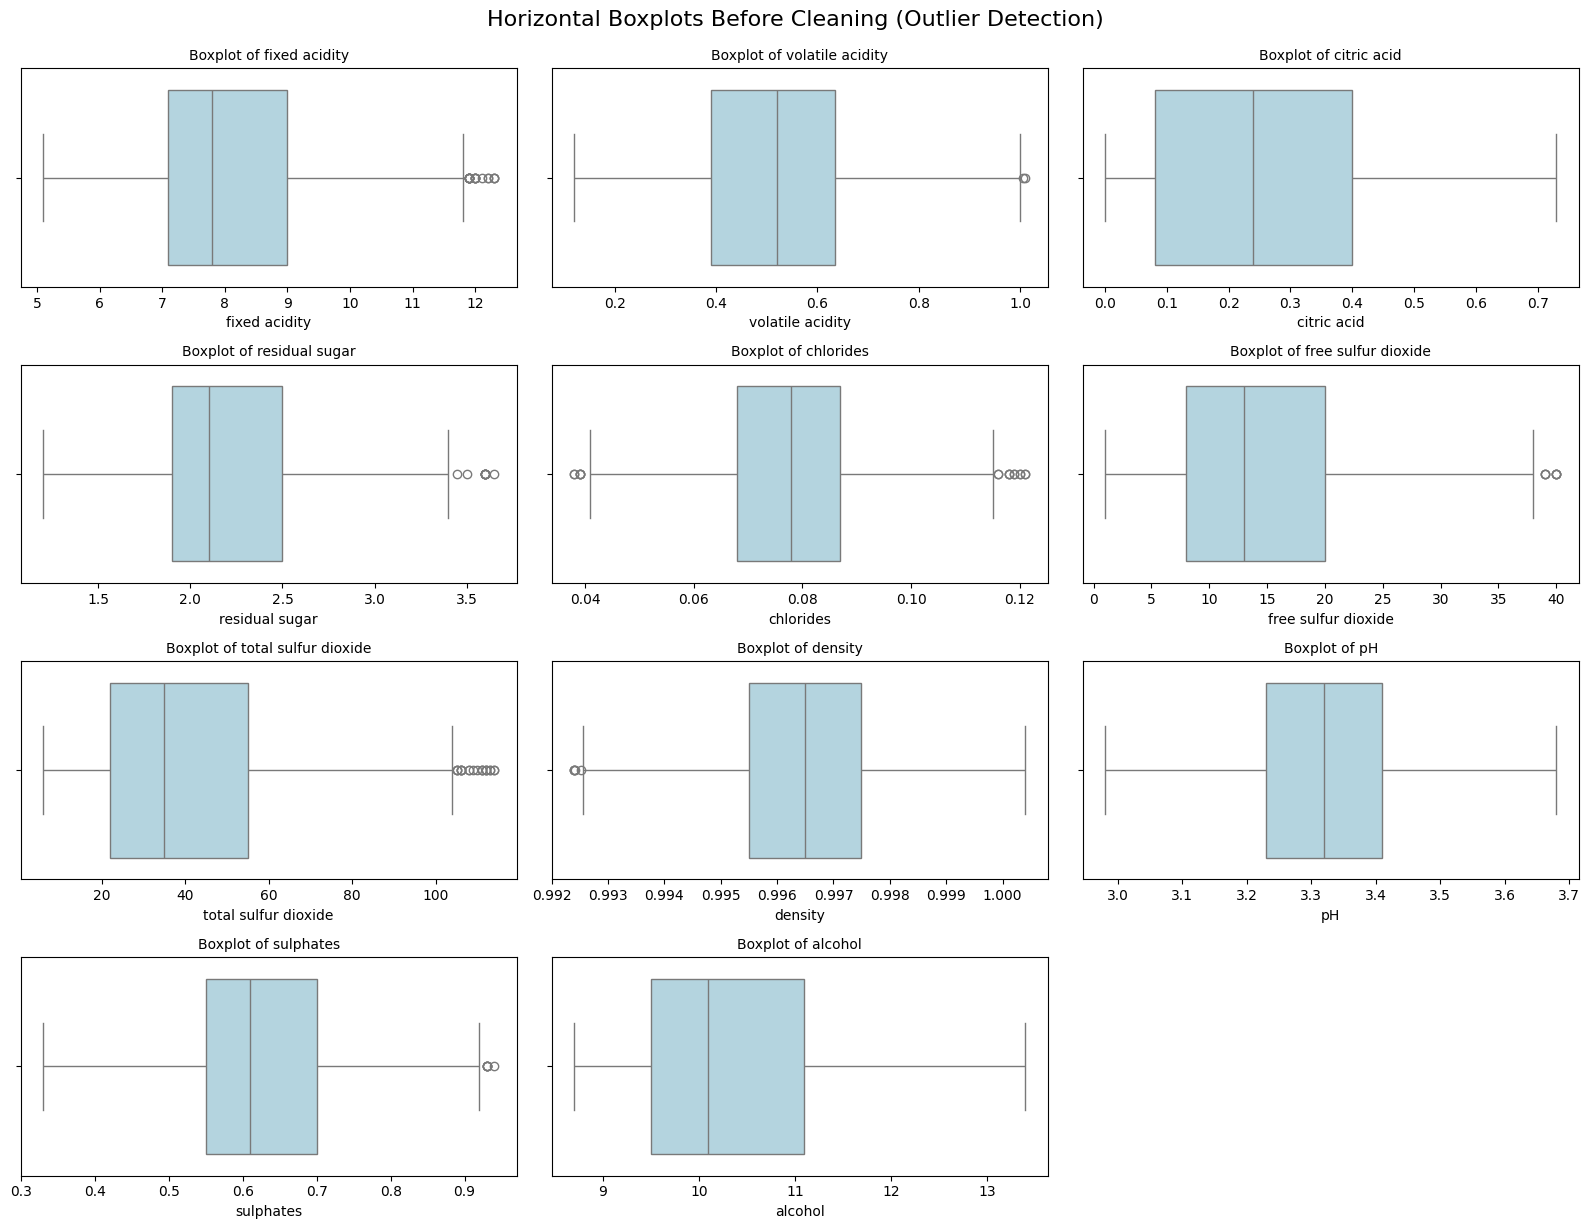

In [18]:
plt.figure(figsize=(16, 12))

# Loop to plot horizontal boxplots
for i, column in enumerate(df.columns[:-1], 1):  # Exclude 'quality'
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[column], color="lightblue", orient="h")
    plt.title(f'Boxplot of {column}', fontsize=10)
    plt.tight_layout()

# Overall title
plt.suptitle("Horizontal Boxplots Before Cleaning (Outlier Detection)", fontsize=16, y=1.02)
plt.show()

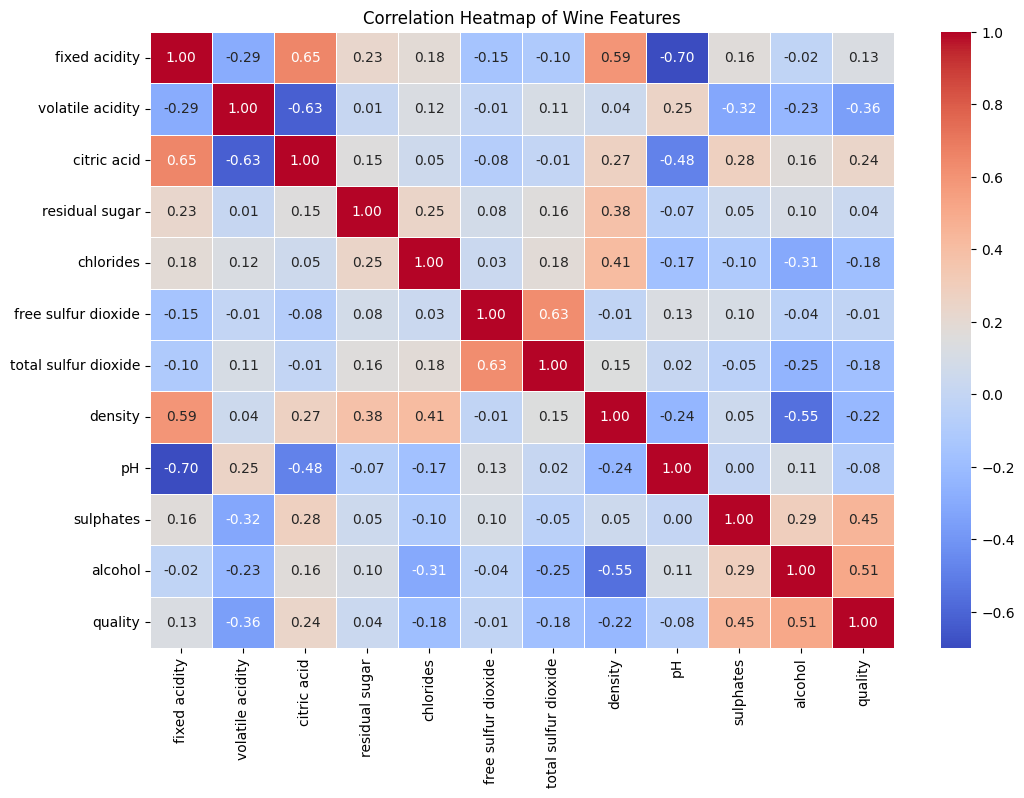

In [19]:
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Heatmap of Wine Features")
plt.show()

In [20]:
df['quality_binary'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)
df = df.drop('quality', axis=1)

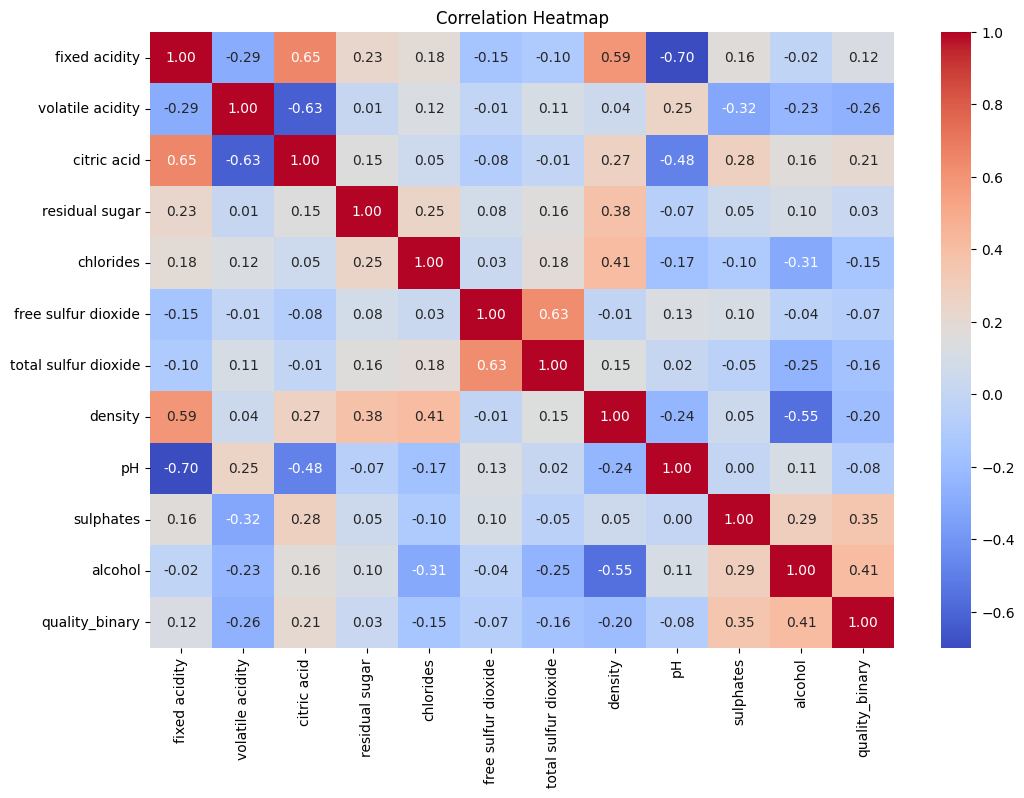

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

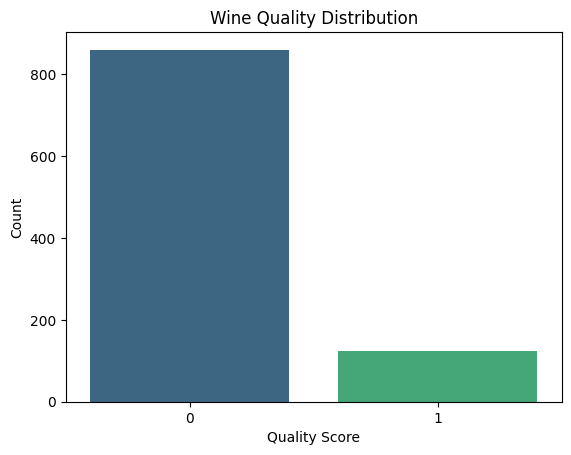

In [24]:
sns.countplot(x='quality_binary', data=df, palette='viridis')
plt.title("Wine Quality Distribution")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()

In [26]:
X = df.drop('quality_binary', axis=1)
y = df['quality_binary']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [41]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [42]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

In [43]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [44]:
# Fit the tuned model
random_search.fit(X_train_resampled, y_train_resampled)
best_model = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [45]:

y_pred = best_model.predict(X_test_scaled)

In [46]:
print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred))
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       172
           1       0.52      0.64      0.57        25

    accuracy                           0.88       197
   macro avg       0.73      0.78      0.75       197
weighted avg       0.89      0.88      0.88       197

✅ Accuracy Score: 0.8781725888324873
📊 Confusion Matrix:
 [[157  15]
 [  9  16]]


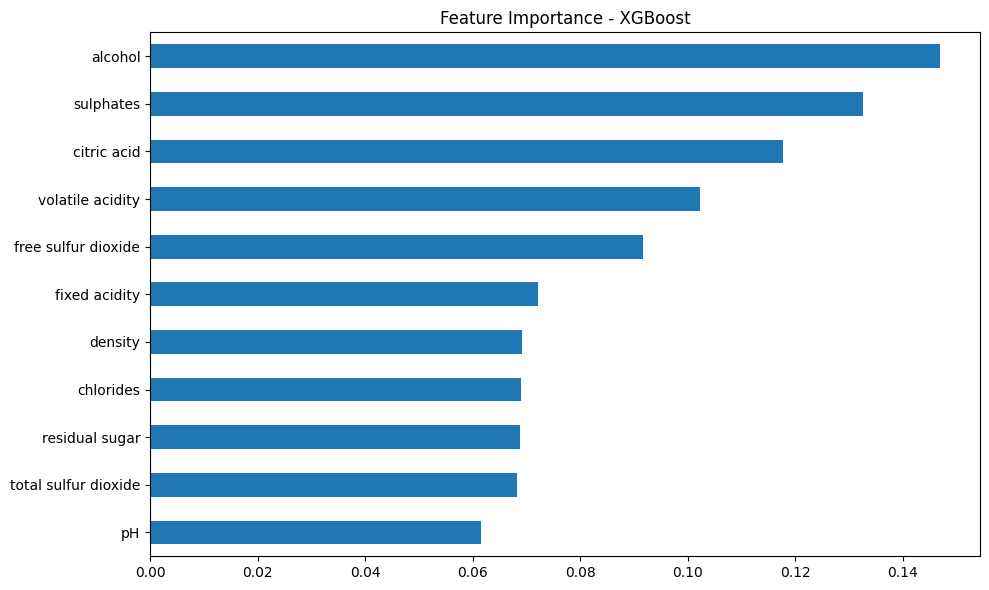

In [47]:
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
feature_importance.sort_values().plot(kind='barh', figsize=(10,6), title="Feature Importance - XGBoost")
plt.tight_layout()
plt.show()